# IMPORTS

In [2]:
# Default imports
import os

# Third party libraries
import pandas as ps
import numpy as np
import setuptools.dist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adagrad
from kerastuner.tuners import Hyperband
import keras


C:\Users\damla\AppData\Local\Temp\ipykernel_38032\1338529229.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# LOAD DATASET

In [4]:
# CONSTANTS
# 0: 5 years dataset
# 1: 10 years dataset
DATA_SET_TO_LOAD = 1

# Defining the paths to the datasets
five_dataset_path = r'./data/raw/5_years.csv'
ten_dataset_path = r'./data/raw/10_years.csv'

# Defining the path to the dataset to be used
active_dataset_path = five_dataset_path if DATA_SET_TO_LOAD == 0 else ten_dataset_path

In [5]:
# Load the dataset
dataset = ps.read_csv(active_dataset_path, parse_dates=['Date'], index_col='Date')
print(dataset.head())

                Close       Open       High        Low  Adj Close     Volume
Date                                                                        
2014-01-02  19.754642  19.845715  19.893929  19.715000  17.296659  234684800
2014-01-03  19.320715  19.745001  19.775000  19.301071  16.916719  392467600
2014-01-06  19.426071  19.194643  19.528570  19.057142  17.008970  412610800
2014-01-07  19.287144  19.440001  19.498571  19.211430  16.887329  317209200
2014-01-08  19.409286  19.243214  19.484285  19.238930  16.994270  258529600


In [6]:
# Check for missing values
print(dataset.isnull().sum())

# Check for duplicates
print(dataset.duplicated().sum())

Close        0
Open         0
High         0
Low          0
Adj Close    0
Volume       0
dtype: int64
0


# NORMALIZE DATA

In [7]:
# Normalize the dataset
def normalize_features(df):
    '''
    Normalizes the data in the dataframe
    '''
    cols = df.columns.drop('Close')
    scaler = MinMaxScaler()
    df[cols] = scaler.fit_transform(df[cols])
    
    return df, scaler


def normalize_target(df):
    '''
    Normalizes the data in the dataframe
    '''
    cols = ['Close']
    scaler = MinMaxScaler()
    df[cols] = scaler.fit_transform(df[cols])
    
    return df, scaler
    

# PREPARE AND LOAD DATA


In [8]:
def prepare_data(df, target_col, time_steps=60):
    '''
    Prepares the data for training the LSTM model
    '''
    
    x, y = [], []
    for i in range(len(df) - time_steps):
        x.append(df[i:i + time_steps])
        y.append(df[i + time_steps, target_col])
    return np.array(x), np.array(y)

In [9]:
def preprocess_data(df, method='f_fill', drop = False, constant_fill=0.0):
    '''
    Preprocesses the data for training the LSTM model
    '''
    
    # Handle missing values
    if method == 'f_fill':
        df.fillna(method='ffill', inplace=True)    
    elif method == 'b_fill':
        df.fillna(method='bfill', inplace=True)
    elif method == 'constant':
        df.fillna(constant_fill, inplace=True)

    # Drop missing values
    if drop:
        df.dropna(inplace=True)

    # Check for missing values
    print(df.isnull().sum())
    return df 

In [10]:
TIME_STEPS = 60

df = preprocess_data(dataset, 'b_fill', drop=True)
df_features, feature_scaler = normalize_features(df)
df_target, target_scaler = normalize_target(df)

# Prepare the data 
x,y = prepare_data(df_features.values, df_target.columns.get_loc('Close'), TIME_STEPS)

# Create the training and testing and validation datasets (80% train, 10% test, 10% validation)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

# Print the shapes of the datasets
print(x_train.shape, x_test.shape, x_val.shape)


Close        0
Open         0
High         0
Low          0
Adj Close    0
Volume       0
dtype: int64
(1964, 60, 6) (246, 60, 6) (246, 60, 6)


C:\Users\damla\AppData\Local\Temp\ipykernel_38032\3023603184.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


# Hardcoded Model

Epoch 1/40
172/172 [==============================] - 5s 12ms/step - loss: 5.7150e-04 - val_loss: 0.0169
Epoch 2/40
172/172 [==============================] - 2s 10ms/step - loss: 3.0619e-04 - val_loss: 0.0146
Epoch 3/40
172/172 [==============================] - 2s 10ms/step - loss: 2.0027e-04 - val_loss: 0.0069
Epoch 4/40
172/172 [==============================] - 2s 10ms/step - loss: 1.7403e-04 - val_loss: 0.0028
Epoch 5/40
172/172 [==============================] - 2s 10ms/step - loss: 1.4270e-04 - val_loss: 0.0048
Epoch 6/40
172/172 [==============================] - 2s 10ms/step - loss: 1.1490e-04 - val_loss: 0.0040
Epoch 7/40
172/172 [==============================] - 2s 10ms/step - loss: 1.2692e-04 - val_loss: 0.0066
Epoch 8/40
172/172 [==============================] - 2s 10ms/step - loss: 1.2712e-04 - val_loss: 0.0062
Epoch 9/40
172/172 [==============================] - 2s 10ms/step - loss: 1.1046e-04 - val_loss: 0.0056
Epoch 9: early stopping
8/8 [==========================

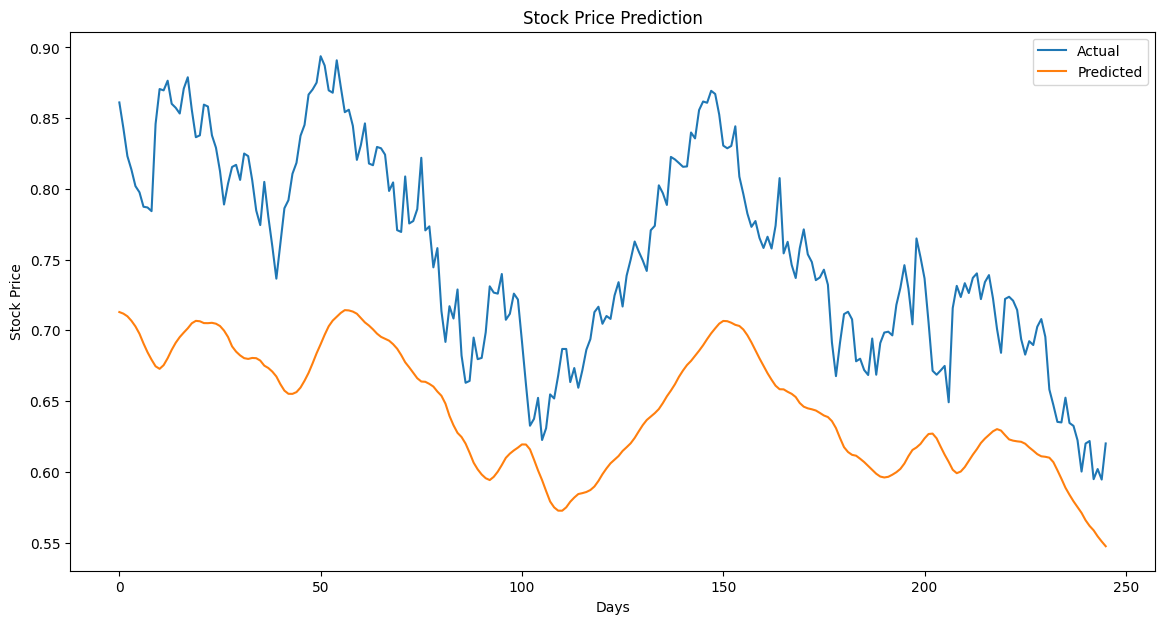

In [11]:
import matplotlib.pyplot as plt

regressor_1 = Sequential()
regressor_1.add(LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
regressor_1.add(Dropout(0.2))
regressor_1.add(LSTM(units=16, return_sequences=False))
regressor_1.add(Dropout(0.2))
regressor_1.add(Dense(units=1, activation='linear'))
regressor_1.compile(optimizer='adam', loss='mse')

es_1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

regressor_1.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=8, callbacks=[es_1])
pred_1 = regressor_1.predict(x_test)
pred_1.shape

plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(pred_1, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [12]:
# regressor_1.save('10year/hardcoded_model')

INFO:tensorflow:Assets written to: 10year/hardcoded_model\assets


INFO:tensorflow:Assets written to: 10year/hardcoded_model\assets


In [13]:
def get_mae_mse_mape(y_true, y_pred):
    '''
    Returns the Mean Absolute Error, Mean Squared Error, and Mean Absolute Percentage Error
    '''
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape

mae, mse, mape = get_mae_mse_mape(y_test, pred_1)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

pred_2 = regressor_1.predict(x_val)
mae, mse, mape = get_mae_mse_mape(y_val, pred_2)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

Mean Absolute Error: 0.11580655147238904
Mean Squared Error: 0.018922067495164997
Mean Absolute Percentage Error: 14.74182114141599
8/8 [==============================] - 0s 6ms/step
Mean Absolute Error: 0.16546824113002392
Mean Squared Error: 0.03611070872056919
Mean Absolute Percentage Error: 18.47545116010618


In [19]:
# https://medium.com/@viniciusqroz/using-keras-tuner-to-find-the-best-parameters-for-your-neural-network-model-2dc02e0a1203
def create_model(hyperparameters):
    '''
    Creates the LSTM model
     n_layers = 2, n_nodes = 50, dropout = 0.2, dense_nodes = 25, learning_rate = 0.001, loss = 'mean_squared_error'
    
    args:
        input_shape: the shape of the input data
        n_layers: the number of LSTM layers
        n_nodes: the number of nodes in each LSTM layer
        dropout: the dropout rate
        loss: the loss function
        optimizer: the optimizer
        dense_nodes: the number of nodes in the dense layer
    '''

    input_shape = (x_train.shape[1], x_train.shape[2])
    
    # Initialize a sequential model, which is a linear stack of layers
    model = Sequential()
    # Add input layer
    model.add(Input(shape=input_shape))
    # Add the first LSTM layer, which is a recurrent layer that has memoryw
    hp_units1 = hyperparameters.Int('units1', min_value=16, max_value=64, step=16)
    model.add(LSTM(units=hp_units1, return_sequences=True))
    # Add a dropout layer to prevent overfitting. This layer will randomly set 20% of the input units to 0 at each update during training time
    hp_dropout1 = hyperparameters.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout1))
    hp_layers = hyperparameters.Int('layers', min_value=1, max_value=3, step=1)
    hp_units2 = hyperparameters.Int('units2', min_value=16, max_value=64, step=16)
    # Add the remaining LSTM layers
    for i in range(hp_layers - 1):
        model.add(LSTM(hp_units2, return_sequences=True))
        model.add(Dropout(hp_dropout1))
    
    # Add a intermediate dense layer
    hp_dense_nodes = hyperparameters.Int('dense_nodes', min_value=1, max_value=64, step=16)
    model.add(Dense(hp_units1))
    
    # Compile the model
    model.compile(loss="mse", optimizer='adam', metrics=['mse'])
    
    # Return the model
    return model

In [20]:
tuner = Hyperband(
    create_model,
    objective='mean_squared_error',
    max_epochs=100,
    directory='test-2/hyperband',
    project_name='stock_price_prediction')

In [21]:
tuner.search(x_train, y_train, epochs=40, validation_data=(x_val, y_val))
best_models = tuner.get_best_models(num_models=1)

Trial 254 Complete [00h 01m 39s]
mean_squared_error: 0.06336378306150436

Best mean_squared_error So Far: 0.06235389783978462
Total elapsed time: 00h 48m 36s


In [26]:
best_models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            19968     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 288)           406656    
                                                                 
 dropout_1 (Dropout)         (None, 60, 288)           0         
                                                                 
 dense (Dense)               (None, 60, 64)            18496     
                                                                 
 batch_normalization (BatchN  (None, 60, 64)           256       
 ormalization)                                                   
                                                        

In [59]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

model = tuner.hypermodel.build(best_hyperparameters)
fitted_model = model.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), batch_size=64, shuffle=False)#, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)])

model.save(f'5year/model')

{'units1': 64, 'dropout1': 0.2, 'layers': 2, 'units2': 288, 'learning_rate': 0.01, 'tuner/epochs': 34, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/1000
15/15 [==============================] - 2s 47ms/step - loss: 3.7572 - mean_squared_error: 3.7572 - val_loss: 11.2806 - val_mean_squared_error: 11.2806
Epoch 2/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.3031 - mean_squared_error: 0.3031 - val_loss: 7.4025 - val_mean_squared_error: 7.4025
Epoch 3/1000
15/15 [==============================] - 0s 13ms/step - loss: 0.0801 - mean_squared_error: 0.0801 - val_loss: 2.7362 - val_mean_squared_error: 2.7362
Epoch 4/1000
15/15 [==============================] - 0s 13ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 1.2803 - val_mean_squared_error: 1.2803
Epoch 5/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0866 - mean_squared_error: 0.0866 - val_loss: 1.0952 - val_mean_squared_error: 1.0952
Epoch 6/1000
15/

INFO:tensorflow:Assets written to: 5year/model\assets


INFO:tensorflow:Assets written to: 5year/model\assets


In [60]:
# evaluate the model
train_loss = model.evaluate(x_train, y_train, verbose=0)
val_loss = model.evaluate(x_val, y_val, verbose=0)

print('Train loss:', train_loss)
print('Validation loss:', val_loss)

Train loss: [0.06286703050136566, 0.06286704540252686]
Validation loss: [0.16628125309944153, 0.16628125309944153]


4/4 [==============================] - 0s 21ms/step
(120,)
Mean Squared Error: 2423.922722295336
Mean Absolute Error: 46.96106445367136
Mean Absolute Percentage Error: 0.27897091128564633


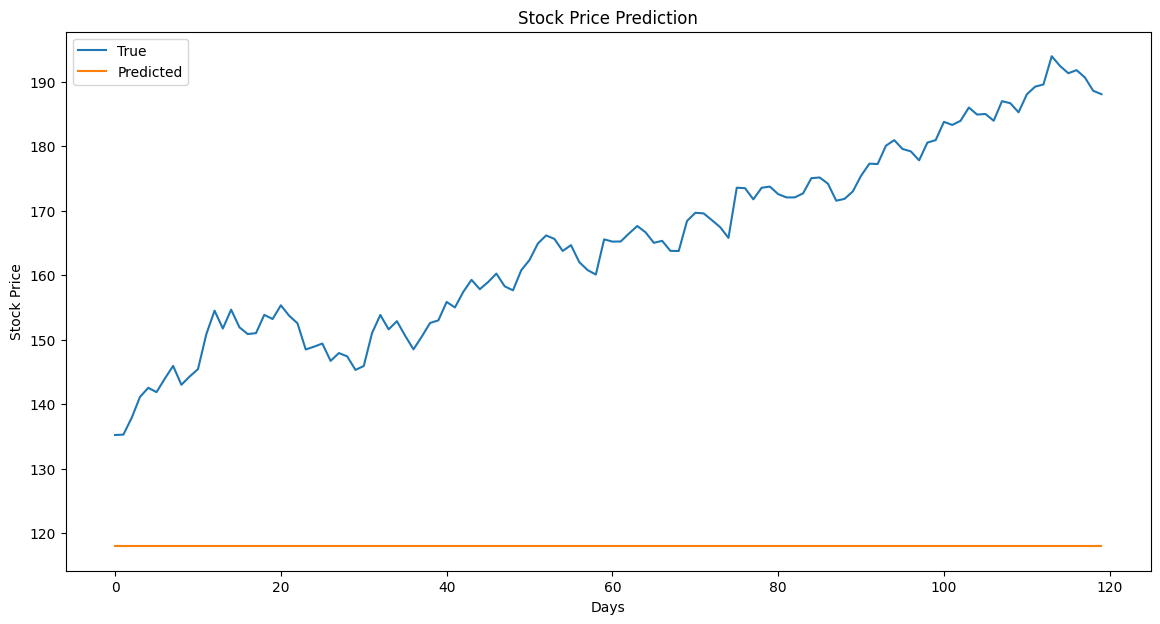

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


# predict the future stock prices
predictions = model.predict(x_test)

# preprocess the predictions
pred = []
for i in range(len(predictions)):
    pred.append(predictions[i][0].item())
pred = np.array(pred)

print(pred.shape)

# inverse the normalization
predictions_reshaped = pred.reshape(-1, 1)
predictions_inversed = target_scaler.inverse_transform(predictions_reshaped) # gives ValueError: Found array with dim 3. None expected <= 2.
y_test_reshaped = y_test.reshape(-1, 1)
y_test_inversed = target_scaler.inverse_transform(y_test_reshaped)

mse_model = mean_squared_error(y_test_inversed, predictions_inversed)
mae_model = mean_absolute_error(y_test_inversed, predictions_inversed)
mape_model = mean_absolute_percentage_error(y_test_inversed, predictions_inversed)

print('Mean Squared Error:', mse_model)
print('Mean Absolute Error:', mae_model)
print('Mean Absolute Percentage Error:', mape_model)


import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test_inversed, label='True')
plt.plot(predictions_inversed, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [62]:
print("True Mean ", y_test_inversed.mean())
print("True Std  ", y_test_inversed.std())

print("Pred Mean ", predictions_inversed.mean())
print("Pred Std  ", predictions_inversed.std())

True Mean  164.9175833384196
True Std   14.78449010529143
Pred Mean  117.95651888474823
Pred Std   0.0
